In [1]:
import torch

if torch.cuda.is_available():
    torch.cuda.empty_cache()

In [2]:
print(torch.cuda.is_available())  # Should print True

True


In [3]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data, Batch
from torch_geometric.nn import GCNConv  # Example GCNConv
from sklearn.neighbors import NearestNeighbors
import numpy as np
import pandas as pd

# 1. Load and prepare data
obsmat_df = pd.read_csv("ewap_dataset/seq_eth/obsmat.txt", sep='\s+', header=None)
obsmat_df.columns = ['frame_number', 'pedestrian_ID', 'pos_x', 'pos_z', 'pos_y', 'v_x', 'v_z', 'v_y']
obsmat_df.drop(['pos_z', 'v_z'], axis=1, inplace=True)

# Compute mean and std over the entire dataset for positions and velocities.
mean = obsmat_df[['pos_x', 'pos_y', 'v_x', 'v_y']].mean()
std = obsmat_df[['pos_x', 'pos_y', 'v_x', 'v_y']].std()

# Normalize the columns.
obsmat_df[['pos_x', 'pos_y', 'v_x', 'v_y']] = (obsmat_df[['pos_x', 'pos_y', 'v_x', 'v_y']] - mean) / std

# 2. Graph creation function
def create_graph(frame_data, k=2):
    positions = frame_data[['pos_x', 'pos_y']].values
    velocities = frame_data[['v_x', 'v_y']].values
    # pedestrian = frame_data['pedestrian_ID'].values
    features = np.concatenate([positions, velocities], axis=1)
    num_pedestrians = len(positions)

    if num_pedestrians > 1:
        knn = NearestNeighbors(n_neighbors=max(k, num_pedestrians - 1))
        knn.fit(positions)
        _, indices = knn.kneighbors(positions)

        edge_index = []
        for i in range(len(positions)):
            for j in indices[i]:
                if i != j:
                    # edge_index.append([pedestrian[i], pedestrian[j]])
                    edge_index.append([i, j])

        edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
        x = torch.tensor(features, dtype=torch.float)
        data = Data(x=x, edge_index=edge_index)
        return data
    elif num_pedestrians == 1:
        x = torch.tensor(features, dtype=torch.float)
        # edge_index = torch.tensor([[pedestrian[0]], [pedestrian[0]]], dtype=torch.long)
        edge_index = torch.tensor([[0], [0]], dtype=torch.long)
        data = Data(x=x, edge_index=edge_index)  # self edge_index if only one pedestrian.
        return data
    else: # if there is no pedestrian in the frame
      return None


# 3. Create graphs for all frames and batch them
graph_list = []
frames = obsmat_df.groupby('frame_number')
for frame_id, frame_number in frames:
    graph = create_graph(frame_number)
    if(graph is not None):
        graph_list.append(graph)

# for data in graph_list:
#     if not hasattr(data, 'edge_index'):
#         data.edge_index = torch.tensor([[], []], dtype=torch.long)

# filtered_graph_list = [data for data in graph_list if hasattr(data, 'edge_index')]
# data_batch = Batch.from_data_list(graph_list)
# print(data_batch)

data_batch = Batch.from_data_list(graph_list) #This is the batched data ready for the GNN
print(data_batch)

# 4. Feature Scaling (Important!)
# Calculate mean and std *across all frames* for each feature
feature_means = data_batch.x.mean(dim=0)
feature_stds = data_batch.x.std(dim=0)

# Normalize the features in the batched graph
data_batch.x = (data_batch.x - feature_means) / (feature_stds + 1e-7)  # Adding a small epsilon for numerical stability


# Now 'data_batch' is ready to be passed to your GNN model.
# Example usage (assuming you have a 'model' defined):
# output = model(data_batch.x, data_batch.edge_index)


<>:10: SyntaxWarning: invalid escape sequence '\s'
<>:10: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_1509/355509994.py:10: SyntaxWarning: invalid escape sequence '\s'
  obsmat_df = pd.read_csv("ewap_dataset/seq_eth/obsmat.txt", sep='\s+', header=None)


DataBatch(x=[8908, 4], edge_index=[2, 66418], batch=[8908], ptr=[1449])


In [4]:
import torch

if torch.cuda.is_available():
    torch.cuda.empty_cache()

In [ ]:
# #trail to check for work

# frame_data = obsmat_df.groupby('frame_number').get_group(834)

# # print(f"First Frame ID: {first_frame_id}")
# print("Frame Data:")
# # print(frame_data)

# positions = frame_data[['pos_x', 'pos_y']].values
# velocities = frame_data[['v_x', 'v_y']].values
# features = np.concatenate([positions, velocities], axis=1)
# pedestrian_ids = frame_data['pedestrian_ID'].values  # Get pedestrian IDs
# num_pedestrians = len(positions)

# if num_pedestrians > 1:
#     knn = NearestNeighbors(n_neighbors=max(2, num_pedestrians - 1))
#     knn.fit(positions)
#     _, indices = knn.kneighbors(positions)

#     node_indices = {ped_id: i for i, ped_id in enumerate(pedestrian_ids)}
#     edge_index = []
#     for i, ped_id_i in enumerate(pedestrian_ids):
#         for j_idx in indices[i]:
#             ped_id_j = pedestrian_ids[j_idx]
#             if ped_id_i != ped_id_j:
#                 edge_index.append([node_indices[ped_id_i], node_indices[ped_id_j]])

#     edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
#     x = torch.tensor(features, dtype=torch.float)
#     data = Data(x=x, edge_index=edge_index)

# # data.edge_index
# edge_index

Frame Data:


tensor([[0, 1],
        [1, 0]])

In [5]:
graph_list

[Data(x=[1, 4], edge_index=[2, 1]),
 Data(x=[1, 4], edge_index=[2, 1]),
 Data(x=[1, 4], edge_index=[2, 1]),
 Data(x=[1, 4], edge_index=[2, 1]),
 Data(x=[2, 4], edge_index=[2, 2]),
 Data(x=[2, 4], edge_index=[2, 2]),
 Data(x=[2, 4], edge_index=[2, 2]),
 Data(x=[1, 4], edge_index=[2, 1]),
 Data(x=[1, 4], edge_index=[2, 1]),
 Data(x=[2, 4], edge_index=[2, 2]),
 Data(x=[2, 4], edge_index=[2, 2]),
 Data(x=[5, 4], edge_index=[2, 15]),
 Data(x=[5, 4], edge_index=[2, 15]),
 Data(x=[5, 4], edge_index=[2, 15]),
 Data(x=[5, 4], edge_index=[2, 15]),
 Data(x=[5, 4], edge_index=[2, 15]),
 Data(x=[5, 4], edge_index=[2, 15]),
 Data(x=[5, 4], edge_index=[2, 15]),
 Data(x=[5, 4], edge_index=[2, 15]),
 Data(x=[5, 4], edge_index=[2, 15]),
 Data(x=[5, 4], edge_index=[2, 15]),
 Data(x=[5, 4], edge_index=[2, 15]),
 Data(x=[5, 4], edge_index=[2, 15]),
 Data(x=[5, 4], edge_index=[2, 15]),
 Data(x=[5, 4], edge_index=[2, 15]),
 Data(x=[6, 4], edge_index=[2, 24]),
 Data(x=[6, 4], edge_index=[2, 24]),
 Data(x=[6, 

In [9]:
print(graph_list[1].edge_index)

tensor([[0],
        [0]])


In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch_geometric.nn import GCNConv, GATConv, global_mean_pool
from torch.utils.data import Dataset, DataLoader


In [8]:
##############################################
# 1. Define the Models
##############################################

In [12]:
# (a) GNN Model: Processes a graph per frame.
class PedestrianGNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, heads=4):
        """
        Args:
            input_dim (int): Dimension of input node features (e.g. 4 for [pos_x, pos_y, v_x, v_y]).
            hidden_dim (int): Hidden dimension for the GCN layers.
            output_dim (int): Output dimension; should match the transformer’s d_model.
        """
        super(PedestrianGNN, self).__init__()
        self.gat1 = GATConv(input_dim, hidden_dim, heads=heads, dropout=0.1)
        self.gat2 = GATConv(hidden_dim * heads, hidden_dim, heads=1, dropout=0.1)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, edge_index, batch):

        x = F.elu(self.gat1(x, edge_index))
        x = F.elu(self.gat2(x, edge_index))
        x = global_mean_pool(x, batch)
        x = self.fc(x)
        return x


In [13]:
import math
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # shape: (1, max_len, d_model)
        self.register_buffer('pe', pe)
    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)

# Transformer with positional encoding.
class TrajectoryTransformerWithPE(nn.Module):
    def __init__(self, d_model, nhead, num_layers, dropout=0.1):
        super(TrajectoryTransformerWithPE, self).__init__()
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        self.transformer = nn.Transformer(
            d_model=d_model,
            nhead=nhead,
            num_encoder_layers=num_layers,
            num_decoder_layers=num_layers,
            dropout=dropout,
            batch_first=True
        )
        self.fc_out = nn.Linear(d_model, 2)
    def forward(self, src, tgt):
        src = self.pos_encoder(src)
        tgt = self.pos_encoder(tgt)
        transformer_output = self.transformer(src, tgt)
        output = self.fc_out(transformer_output)
        return output


In [27]:

##############################################
# 2. Define the Dataset and Collate Function
##############################################

In [14]:
class TrajectoryDataset(Dataset):
    def __init__(self, graph_list, input_seq_len, target_seq_len):
        """
        Args:
            graph_list (list): List of torch_geometric.data.Data objects, one per frame.
            input_seq_len (int): Number of consecutive frames used as input.
            target_seq_len (int): Number of consecutive frames to predict.
        """
        self.graph_list = graph_list
        self.input_seq_len = input_seq_len
        self.target_seq_len = target_seq_len
        self.total_seq_len = input_seq_len + target_seq_len
        if len(self.graph_list) < self.total_seq_len:
            raise ValueError("Not enough frames for the given sequence lengths.")
    def __len__(self):
        return len(self.graph_list) - self.total_seq_len + 1
    def pool_frame(self, frame):
        # Pool the positions (columns 0 and 1) from all nodes.
        return frame.x[:, :2].mean(dim=0)
    def __getitem__(self, idx):
        input_frames = self.graph_list[idx: idx + self.input_seq_len]
        target_frames = self.graph_list[idx + self.input_seq_len: idx + self.total_seq_len]
        tgt_positions = torch.stack([self.pool_frame(frame) for frame in target_frames], dim=0)
        return input_frames, tgt_positions

In [15]:
def collate_fn(batch):
    input_frames_batch = [item[0] for item in batch]
    tgt_positions_batch = torch.stack([item[1] for item in batch], dim=0)
    return input_frames_batch, tgt_positions_batch

In [30]:
##############################################
# 3. Hyperparameters, Dataset, and DataLoader
##############################################

In [16]:
# Set sequence lengths (adjust as needed)
input_seq_len = 8
target_seq_len = 12

# Create dataset and dataloader using the actual BIWI data graphs.
dataset = TrajectoryDataset(graph_list, input_seq_len, target_seq_len)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [20]:
# Hyperparameters.
input_dim = 4        # [pos_x, pos_y, v_x, v_y]
hidden_dim = 64
d_model = 64         # Should equal GNN output dimension.
nhead = 8
num_layers = 2
dropout = 0.1
learning_rate = 1e-3
num_epochs = 10

In [34]:
##############################################
# 4. Instantiate Models, Optimizer, and Loss Function
#############################################

In [21]:
# Instantiate models.
gnn_model = PedestrianGNN(input_dim, hidden_dim, d_model, heads=4).to(device)
transformer_model = TrajectoryTransformerWithPE(d_model, nhead, num_layers, dropout).to(device)

In [22]:
# Decoder input mapping: maps 2D target positions to d_model.
decoder_input_mapping = nn.Linear(2, d_model).to(device)

In [23]:
optimizer = optim.Adam(list(gnn_model.parameters()) +
                       list(transformer_model.parameters()) +
                       list(decoder_input_mapping.parameters()),
                       lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)
criterion = nn.MSELoss()

/home/subhronil/anaconda3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [38]:
##############################################
# 5. The Training Loop
##############################################

In [76]:
import math
import random

In [ ]:
for epoch in range(num_epochs):
    gnn_model.train()
    transformer_model.train()
    decoder_input_mapping.train()
    
    epoch_loss = 0.0
    for batch_idx, (input_frames_batch, tgt_positions_batch) in enumerate(dataloader):
        B = len(input_frames_batch)
        src_embeddings_batch = []  # To hold the sequence embeddings for each sample.
        
        # Process each sample in the batch.
        for sample in input_frames_batch:
            sample_embeddings = []
            for frame in sample:
                x = frame.x.to(device)
                edge_index = frame.edge_index.to(device)
                # Create a batch vector for a single graph (all nodes belong to graph 0).
                batch_vector = torch.zeros(x.size(0), dtype=torch.long).to(device)
                emb = gnn_model(x, edge_index, batch_vector)  # [1, d_model]
                sample_embeddings.append(emb.squeeze(0))       # [d_model]
            sample_seq = torch.stack(sample_embeddings, dim=0)  # [input_seq_len, d_model]
            src_embeddings_batch.append(sample_seq)
        
        src_embeddings = torch.stack(src_embeddings_batch, dim=0)  # [B, input_seq_len, d_model]
        
        # Prepare decoder inputs with teacher forcing:
        # Map ground-truth target positions (except last time step) to d_model space.
        decoder_inputs_mapped = decoder_input_mapping(tgt_positions_batch[:, :-1, :].to(device))  # [B, target_seq_len-1, d_model]
        start_token = torch.zeros(B, 1, d_model, device=device)
        decoder_inputs = torch.cat([start_token, decoder_inputs_mapped], dim=1)  # [B, target_seq_len, d_model]
        
        # Forward pass through the Transformer.
        output = transformer_model(src_embeddings, decoder_inputs)  # [B, target_seq_len, 2]
        
        loss = criterion(output, tgt_positions_batch.to(device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    scheduler.step(avg_loss)
    avg_loss = epoch_loss / len(dataloader)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")

print("Training complete!")

#############################################################################

JUST FOR INFORMATION: THE ACTUAL LOSS AND VALUE WAS TAKEN FROM THE BELOW CODE

#############################################################################

In [ ]:
# # Improved GNN using GAT layers.
# class PedestrianGNN(nn.Module):
#     def __init__(self, input_dim, hidden_dim, output_dim, heads=4):
#         super(PedestrianGNN, self).__init__()
#         self.gat1 = GATConv(input_dim, hidden_dim, heads=heads, dropout=0.1)
#         self.gat2 = GATConv(hidden_dim * heads, hidden_dim, heads=1, dropout=0.1)
#         self.fc = nn.Linear(hidden_dim, output_dim)
#     def forward(self, x, edge_index, batch):
#         x = F.elu(self.gat1(x, edge_index))
#         x = F.elu(self.gat2(x, edge_index))
#         x = global_mean_pool(x, batch)
#         x = self.fc(x)
#         return x

# # Positional Encoding.
# class PositionalEncoding(nn.Module):
#     def __init__(self, d_model, dropout=0.1, max_len=5000):
#         super(PositionalEncoding, self).__init__()
#         self.dropout = nn.Dropout(p=dropout)
#         pe = torch.zeros(max_len, d_model)
#         position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
#         div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
#         pe[:, 0::2] = torch.sin(position * div_term)
#         pe[:, 1::2] = torch.cos(position * div_term)
#         pe = pe.unsqueeze(0)  # shape: (1, max_len, d_model)
#         self.register_buffer('pe', pe)
#     def forward(self, x):
#         x = x + self.pe[:, :x.size(1), :]
#         return self.dropout(x)

# # Transformer with positional encoding.
# class TrajectoryTransformerWithPE(nn.Module):
#     def __init__(self, d_model, nhead, num_layers, dropout=0.1):
#         super(TrajectoryTransformerWithPE, self).__init__()
#         self.pos_encoder = PositionalEncoding(d_model, dropout)
#         self.transformer = nn.Transformer(
#             d_model=d_model,
#             nhead=nhead,
#             num_encoder_layers=num_layers,
#             num_decoder_layers=num_layers,
#             dropout=dropout,
#             batch_first=True
#         )
#         self.fc_out = nn.Linear(d_model, 2)
#     def forward(self, src, tgt):
#         src = self.pos_encoder(src)
#         tgt = self.pos_encoder(tgt)
#         transformer_output = self.transformer(src, tgt)
#         output = self.fc_out(transformer_output)
#         return output

# ##############################################
# # 3. Trajectory Dataset and Collate Function
# ##############################################

# class TrajectoryDataset(Dataset):
#     def __init__(self, graph_list, input_seq_len, target_seq_len):
#         self.graph_list = graph_list
#         self.input_seq_len = input_seq_len
#         self.target_seq_len = target_seq_len
#         self.total_seq_len = input_seq_len + target_seq_len
#         if len(self.graph_list) < self.total_seq_len:
#             raise ValueError("Not enough frames for the given sequence lengths.")
#     def __len__(self):
#         return len(self.graph_list) - self.total_seq_len + 1
#     def pool_frame(self, frame):
#         # Pool the positions (columns 0 and 1) from all nodes.
#         return frame.x[:, :2].mean(dim=0)
#     def __getitem__(self, idx):
#         input_frames = self.graph_list[idx: idx + self.input_seq_len]
#         target_frames = self.graph_list[idx + self.input_seq_len: idx + self.total_seq_len]
#         tgt_positions = torch.stack([self.pool_frame(frame) for frame in target_frames], dim=0)
#         return input_frames, tgt_positions

# def collate_fn(batch):
#     input_frames_batch = [item[0] for item in batch]
#     tgt_positions_batch = torch.stack([item[1] for item in batch], dim=0)
#     return input_frames_batch, tgt_positions_batch

# # Set sequence lengths (adjust as needed)
# input_seq_len = 8
# target_seq_len = 12

# # Create dataset and dataloader using the actual BIWI data graphs.
# dataset = TrajectoryDataset(graph_list, input_seq_len, target_seq_len)
# dataloader = DataLoader(dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)

# ##############################################
# # 4. Initialize Models, Optimizer, and Loss Function
# ##############################################

# # Hyperparameters.
# input_dim = 4        # [pos_x, pos_y, v_x, v_y]
# hidden_dim = 64
# d_model = 64         # Should equal GNN output dimension.
# nhead = 8
# num_layers = 2
# dropout = 0.1
# learning_rate = 1e-3
# num_epochs = 10

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Instantiate models.
# gnn_model = PedestrianGNN(input_dim, hidden_dim, d_model, heads=4).to(device)
# transformer_model = TrajectoryTransformerWithPE(d_model, nhead, num_layers, dropout).to(device)
# # Decoder input mapping: maps 2D target positions to d_model.
# decoder_input_mapping = nn.Linear(2, d_model).to(device)

# optimizer = optim.Adam(list(gnn_model.parameters()) +
#                        list(transformer_model.parameters()) +
#                        list(decoder_input_mapping.parameters()),
#                        lr=learning_rate)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)
# criterion = nn.MSELoss()

# ##############################################
# # 5. Training Loop
# ##############################################

# for epoch in range(num_epochs):
#     gnn_model.train()
#     transformer_model.train()
#     decoder_input_mapping.train()
    
#     epoch_loss = 0.0
#     for batch_idx, (input_frames_batch, tgt_positions_batch) in enumerate(dataloader):
#         B = len(input_frames_batch)
#         src_embeddings_batch = []  # To hold the sequence embeddings for each sample.
        
#         # Process each sample in the batch.
#         for sample in input_frames_batch:
#             sample_embeddings = []
#             for frame in sample:
#                 x = frame.x.to(device)
#                 edge_index = frame.edge_index.to(device)
#                 # Create a batch vector for a single graph (all nodes belong to graph 0).
#                 batch_vector = torch.zeros(x.size(0), dtype=torch.long).to(device)
#                 emb = gnn_model(x, edge_index, batch_vector)  # [1, d_model]
#                 sample_embeddings.append(emb.squeeze(0))       # [d_model]
#             sample_seq = torch.stack(sample_embeddings, dim=0)  # [input_seq_len, d_model]
#             src_embeddings_batch.append(sample_seq)
        
#         src_embeddings = torch.stack(src_embeddings_batch, dim=0)  # [B, input_seq_len, d_model]
        
#         # Prepare decoder inputs with teacher forcing:
#         # Map ground-truth target positions (except last time step) to d_model space.
#         decoder_inputs_mapped = decoder_input_mapping(tgt_positions_batch[:, :-1, :].to(device))  # [B, target_seq_len-1, d_model]
#         start_token = torch.zeros(B, 1, d_model, device=device)
#         decoder_inputs = torch.cat([start_token, decoder_inputs_mapped], dim=1)  # [B, target_seq_len, d_model]
        
#         # Forward pass through the Transformer.
#         output = transformer_model(src_embeddings, decoder_inputs)  # [B, target_seq_len, 2]
        
#         loss = criterion(output, tgt_positions_batch.to(device))
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
        
#         epoch_loss += loss.item()
#     scheduler.step(avg_loss)
#     avg_loss = epoch_loss / len(dataloader)
#     print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")

# print("Training complete!")

Epoch 1/10, Loss: 0.1209
Epoch 2/10, Loss: 0.0563
Epoch 3/10, Loss: 0.0460
Epoch 4/10, Loss: 0.0425
Epoch 5/10, Loss: 0.0377
Epoch 6/10, Loss: 0.0351
Epoch 7/10, Loss: 0.0351
Epoch 8/10, Loss: 0.0328
Epoch 9/10, Loss: 0.0294
Epoch 10/10, Loss: 0.0317
Training complete!


In [100]:
import torch

# Assuming these are your trained model instances:
# gnn_model, transformer_model, decoder_input_mapping
# And your optimizer is 'optimizer'

# Save checkpoint after training
checkpoint = {
    'epoch': num_epochs,
    'gnn_state_dict': gnn_model.state_dict(),
    'transformer_state_dict': transformer_model.state_dict(),
    'decoder_input_mapping_state_dict': decoder_input_mapping.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': avg_loss,
}

torch.save(checkpoint, 'trajectory_model_checkpoint.pth')
print("Model checkpoint saved.")


Model checkpoint saved.


In [24]:
import torch

if torch.cuda.is_available():
    torch.cuda.empty_cache()

In [25]:
import torch

# Re-create your model architectures with the same parameters
gnn_model = PedestrianGNN(input_dim, hidden_dim, d_model).to(device)
transformer_model = TrajectoryTransformerWithPE(d_model=d_model, nhead=nhead, num_layers=num_layers, dropout=dropout).to(device)
decoder_input_mapping = nn.Linear(2, d_model).to(device)

optimizer = optim.Adam(list(gnn_model.parameters()) +
                       list(transformer_model.parameters()) +
                       list(decoder_input_mapping.parameters()),
                       lr=learning_rate)

# Load checkpoint
checkpoint = torch.load('trajectory_model_checkpoint.pth')
gnn_model.load_state_dict(checkpoint['gnn_state_dict'])
transformer_model.load_state_dict(checkpoint['transformer_state_dict'])
decoder_input_mapping.load_state_dict(checkpoint['decoder_input_mapping_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

start_epoch = checkpoint['epoch']
print(f"Loaded model from epoch {start_epoch} with loss {checkpoint['loss']:.4f}")


/tmp/ipykernel_1509/3769514250.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('trajectory_model_checkpoint.pth')


Loaded model from epoch 10 with loss 0.0317


In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import Data

# Set models to evaluation mode
gnn_model.eval()
transformer_model.eval()
decoder_input_mapping.eval()

# --- Step 1: Prepare Test Input ---
# Use an existing test graph from your graph_list.
test_graph = graph_list[0]  # Using the first graph as an example

# Move test graph data to the correct device
test_graph.x = test_graph.x.to(device)
test_graph.edge_index = test_graph.edge_index.to(device)

# --- Step 2: Get GNN Embeddings from the Test Graph ---
with torch.no_grad():
    # Create a dummy batch vector for the test graph's nodes on the device
    dummy_batch = torch.zeros(test_graph.x.shape[0], dtype=torch.long, device=device)
    # Pass test graph through GNN to get node embeddings
    test_gnn_output = gnn_model(test_graph.x, test_graph.edge_index, dummy_batch)  # Now provides expected output
    # Treat the nodes as a sequence (if your Transformer expects a sequence, add a batch dimension)
    test_src = test_gnn_output.unsqueeze(0)  # Shape: (1, num_nodes, d_model)

# --- Step 3: Prepare Decoder Input for the Transformer ---
dummy_decoder_input = torch.zeros(1, target_seq_len, 2, device=device)
decoder_inputs = decoder_input_mapping(dummy_decoder_input)  # Shape: (1, target_seq_len, d_model)

# --- Step 4: Run the Transformer to Get Predicted Trajectories ---
with torch.no_grad():
    predictions = transformer_model(test_src, decoder_inputs)
    print("Predicted Trajectories:", predictions)


Predicted Trajectories: tensor([[[-0.0679, -0.0402],
         [-0.0675, -0.0460],
         [-0.0523, -0.0518],
         [-0.0426, -0.0495],
         [-0.0363, -0.0457],
         [-0.0348, -0.0424],
         [-0.0377, -0.0439],
         [-0.0381, -0.0460],
         [-0.0373, -0.0508],
         [-0.0368, -0.0490],
         [-0.0221, -0.0467],
         [-0.0081, -0.0435]]], device='cuda:0')


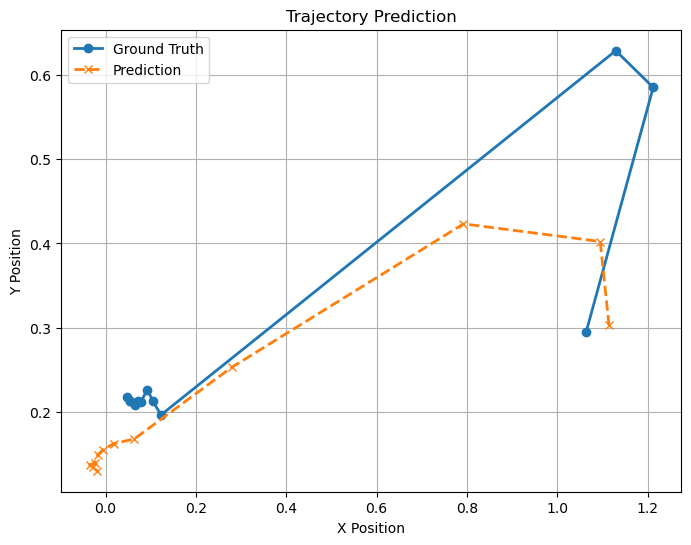

In [30]:
import matplotlib.pyplot as plt
import torch

def get_sample(sample_index, dataset, device):
    """
    Returns the ground truth and predicted trajectories for a single sample.
    
    Args:
        sample_index (int): Index into the dataset.
        dataset (TrajectoryDataset): Your dataset built from BIWI data.
        device (torch.device): Device (CPU or GPU) on which the models are.
    
    Returns:
        true_positions (numpy array): Ground truth trajectory [target_seq_len, 2].
        pred_positions (numpy array): Predicted trajectory [target_seq_len, 2].
    """
    # Get a single sample from the dataset:
    input_frames, tgt_positions = dataset[sample_index]
    
    # Process input frames with the GNN to get a sequence of embeddings:
    frame_embeddings = []
    for frame in input_frames:
        x = frame.x.to(device)
        edge_index = frame.edge_index.to(device)
        # For a single graph, create a batch vector (all nodes belong to graph 0)
        batch_vector = torch.zeros(x.size(0), dtype=torch.long).to(device)
        node_embeddings = gnn_model(x, edge_index, batch_vector)  # [1, d_model]
        # Here, we already have a graph-level embedding, so we simply squeeze it.
        frame_emb = node_embeddings.squeeze(0)  # [d_model]
        frame_embeddings.append(frame_emb)
    
    # Stack frame embeddings to form the source sequence for the Transformer.
    src_embeddings = torch.stack(frame_embeddings, dim=0)  # [input_seq_len, d_model]
    src_embeddings = src_embeddings.unsqueeze(0)  # [1, input_seq_len, d_model]
    
    # Prepare decoder input using teacher forcing:
    # Convert ground-truth target positions (shape: [target_seq_len, 2]) to tensor
    tgt_positions_tensor = tgt_positions.unsqueeze(0).to(device)  # [1, target_seq_len, 2]
    # Map ground truth positions (except the last time step) into the Transformer embedding space.
    decoder_inputs_mapped = decoder_input_mapping(tgt_positions_tensor[:, :-1, :])  # [1, target_seq_len-1, d_model]
    # Create a start token (zeros)
    start_token = torch.zeros(1, 1, src_embeddings.size(-1), device=device)
    # Form the decoder input: [1, target_seq_len, d_model]
    decoder_inputs = torch.cat([start_token, decoder_inputs_mapped], dim=1)
    
    # Get prediction from the Transformer.
    with torch.no_grad():
        pred_positions = transformer_model(src_embeddings, decoder_inputs)  # [1, target_seq_len, 2]
    pred_positions = pred_positions.squeeze(0).cpu().numpy()  # [target_seq_len, 2]
    true_positions = tgt_positions.cpu().numpy()              # [target_seq_len, 2]
    
    return true_positions, pred_positions

# Choose a sample index from your dataset (e.g., 0)
sample_index = 0
true_positions, pred_positions = get_sample(sample_index, dataset, device)

# Plot ground-truth vs. predicted trajectory:
plt.figure(figsize=(8,6))
plt.plot(true_positions[:, 0], true_positions[:, 1], 'o-', label="Ground Truth", linewidth=2)
plt.plot(pred_positions[:, 0], pred_positions[:, 1], 'x--', label="Prediction", linewidth=2)
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.title("Trajectory Prediction")
plt.legend()
plt.grid(True)
plt.show()


In [32]:
import numpy as np

def denormalize_positions(positions, mean_vals, std_vals):
    """
    Denormalizes the positions using mean and std values.
    
    Args:
        positions (numpy array): Shape [T, 2] in normalized units.
        mean_vals (pandas Series or dict): Mean values for 'pos_x' and 'pos_y'.
        std_vals (pandas Series or dict): Standard deviation values for 'pos_x' and 'pos_y'.
        
    Returns:
        numpy array: Denormalized positions in real-world units.
    """
    # Extract mean and std for positions (pos_x, pos_y)
    pos_mean = np.array([mean_vals['pos_x'], mean_vals['pos_y']])
    pos_std = np.array([std_vals['pos_x'], std_vals['pos_y']])
    
    # Denormalize: original = normalized * std + mean
    denorm_positions = positions * pos_std + pos_mean
    return denorm_positions

def compute_ADE_FDE(pred_positions, true_positions):
    """
    Computes Average Displacement Error (ADE) and Final Displacement Error (FDE).
    
    Args:
        pred_positions (numpy array): Predicted trajectory, shape [T, 2].
        true_positions (numpy array): Ground truth trajectory, shape [T, 2].
    
    Returns:
        ADE (float): Average displacement error.
        FDE (float): Final displacement error.
    """
    errors = np.linalg.norm(pred_positions - true_positions, axis=1)
    ADE = errors.mean()
    FDE = errors[-1]
    return ADE, FDE

# Example: assume get_sample returns normalized predictions and ground truth.
true_positions_norm, pred_positions_norm = get_sample(sample_index, dataset, device)

# Denormalize the positions:
true_positions_denorm = denormalize_positions(true_positions_norm, mean, std)
pred_positions_denorm = denormalize_positions(pred_positions_norm, mean, std)

# Compute ADE and FDE:
ADE, FDE = compute_ADE_FDE(pred_positions_denorm, true_positions_denorm)
print(f"Denormalized ADE: {ADE:.4f}")
print(f"Denormalized FDE: {FDE:.4f}")

Denormalized ADE: 0.5937
Denormalized FDE: 0.2579


In [31]:
import torch

if torch.cuda.is_available():
    torch.cuda.empty_cache()

In [24]:
import torch
import numpy as np

def evaluate_model(dataset, gnn_model, transformer_model, decoder_input_mapping, device):
    """
    Evaluate the model on the given dataset and compute average ADE and FDE.
    
    Args:
        dataset: An instance of your TrajectoryDataset.
        gnn_model: The trained GNN model.
        transformer_model: The trained Transformer model.
        decoder_input_mapping: The linear layer mapping 2D positions to d_model.
        device: torch.device where the models reside.
        
    Returns:
        avg_ADE (float): Average Displacement Error averaged over all samples.
        avg_FDE (float): Final Displacement Error averaged over all samples.
    """
    gnn_model.eval()
    transformer_model.eval()
    decoder_input_mapping.eval()
    
    total_ADE = 0.0
    total_FDE = 0.0
    count = 0
    
    with torch.no_grad():
        for sample_index in range(len(dataset)):
            # Get one sample from the dataset:
            input_frames, tgt_positions = dataset[sample_index]
            
            # Process input frames with the GNN to obtain the source embeddings.
            frame_embeddings = []
            for frame in input_frames:
                x = frame.x.to(device)
                edge_index = frame.edge_index.to(device)
                # Create a batch vector for a single graph (all nodes belong to graph 0)
                batch_vector = torch.zeros(x.size(0), dtype=torch.long).to(device)
                emb = gnn_model(x, edge_index, batch_vector)  # Output shape: [1, d_model]
                frame_embeddings.append(emb.squeeze(0))       # [d_model]
            
            # Stack the embeddings to form the source sequence: [1, input_seq_len, d_model]
            src_embeddings = torch.stack(frame_embeddings, dim=0).unsqueeze(0)
            
            # Prepare decoder input using teacher forcing:
            # Convert target positions tensor to shape [1, target_seq_len, 2]
            tgt_positions_tensor = tgt_positions.unsqueeze(0).to(device)
            # Map ground truth positions (except the last time step) to the decoder embedding space.
            decoder_inputs_mapped = decoder_input_mapping(tgt_positions_tensor[:, :-1, :])
            # Create a start token (zeros) and prepend it.
            start_token = torch.zeros(1, 1, src_embeddings.size(-1), device=device)
            decoder_inputs = torch.cat([start_token, decoder_inputs_mapped], dim=1)
            
            # Get the predicted trajectory from the Transformer.
            pred_positions = transformer_model(src_embeddings, decoder_inputs)  # [1, target_seq_len, 2]
            pred_positions = pred_positions.squeeze(0).cpu().numpy()  # [target_seq_len, 2]
            true_positions = tgt_positions.cpu().numpy()              # [target_seq_len, 2]
            
            # Compute Euclidean distances per timestep:
            errors = np.linalg.norm(pred_positions - true_positions, axis=1)
            ADE = errors.mean()
            FDE = errors[-1]
            
            total_ADE += ADE
            total_FDE += FDE
            count += 1
    
    avg_ADE = total_ADE / count
    avg_FDE = total_FDE / count
    return avg_ADE, avg_FDE

# Evaluate the model on your dataset:
avg_ADE, avg_FDE = evaluate_model(dataset, gnn_model, transformer_model, decoder_input_mapping, device)
print(f"Average ADE: {avg_ADE:.4f}")
print(f"Average FDE: {avg_FDE:.4f}")


Average ADE: 0.1441
Average FDE: 0.2256


Reinforcement Learning (RL) for Dynamic Behavior

2A. Custom Gym Environment with Trajectory Predictions

In [32]:
import torch

if torch.cuda.is_available():
    torch.cuda.empty_cache()

In [ ]:
# import gym
# from gym import spaces
# import pybullet as p
# import pybullet_data
# import time
# import numpy as np

# class IntegratedDynamicBehaviorEnv(gym.Env):
#     """
#     A custom environment that simulates an agent in a dynamic scenario using PyBullet.
#     The observation is augmented with predicted future trajectories from the GNN+Transformer.
#     """
#     def __init__(self, gnn_model, transformer_model, decoder_input_mapping, 
#                  dataset_history, input_seq_len, target_seq_len, render_mode=False):
#         """
#         Args:
#             gnn_model, transformer_model, decoder_input_mapping: Your trained prediction models.
#             dataset_history: A list of recent frames (graphs) to form the input sequence.
#             input_seq_len (int): Number of past frames used as input.
#             target_seq_len (int): Number of future frames to predict.
#             render_mode (bool): Whether to render the simulation.
#         """
#         super(IntegratedDynamicBehaviorEnv, self).__init__()
#         self.gnn_model = gnn_model
#         self.transformer_model = transformer_model
#         self.decoder_input_mapping = decoder_input_mapping
#         self.input_seq_len = input_seq_len
#         self.target_seq_len = target_seq_len
#         self.render_mode = render_mode
        
#         # Define action space, for example, continuous actions for linear and angular velocity.
#         self.action_space = spaces.Box(low=np.array([-1, -1]), high=np.array([1, 1]), dtype=np.float32)
#         # Define observation space: you can start with agent state (position, orientation)
#         # plus predicted trajectory (flattened). For example, agent (2 dims) + goal (2 dims) + predicted trajectory (target_seq_len*2).
#         obs_dim = 2 + 2 + target_seq_len * 2
#         self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(obs_dim,), dtype=np.float32)
        
#         # PyBullet setup.
#         if self.render_mode:
#             p.connect(p.GUI)
#         else:
#             p.connect(p.DIRECT)
#         p.setAdditionalSearchPath(pybullet_data.getDataPath())
#         self._setup_simulation()
        
#         # For simplicity, initialize history with a fixed list (in practice, update this over time).
#         self.history = dataset_history  # Assume this is a list of recent graph frames (length >= input_seq_len)
    
#     def _setup_simulation(self):
#         p.resetSimulation()
#         p.setGravity(0, 0, -9.8)
#         self.plane = p.loadURDF("plane.urdf")
#         # Load a simple agent (using, e.g., r2d2.urdf)
#         start_pos = [0, 0, 0.1]
#         start_orientation = p.getQuaternionFromEuler([0, 0, 0])
#         self.agent = p.loadURDF("r2d2.urdf", start_pos, start_orientation)
#         # Define a random goal position.
#         self.goal = np.array([np.random.uniform(-5, 5), np.random.uniform(-5, 5)])
#         self.current_step = 0

#     def _get_agent_state(self):
#         pos, _ = p.getBasePositionAndOrientation(self.agent)
#         pos = np.array(pos)[:2]
#         return pos

#     def _predict_trajectory(self):
#         """
#         Use the last input_seq_len frames from self.history to predict future positions.
#         """
#         if len(self.history) < self.input_seq_len:
#             # Not enough history: return zeros.
#             return np.zeros((self.target_seq_len, 2))
        
#         input_frames = self.history[-self.input_seq_len:]
#         sample_embeddings = []
#         for frame in input_frames:
#             x = frame.x.to(device)
#             edge_index = frame.edge_index.to(device)
#             batch_vector = torch.zeros(x.size(0), dtype=torch.long, device=device)
#             emb = self.gnn_model(x, edge_index, batch_vector)
#             sample_embeddings.append(emb.squeeze(0))
#         src_embeddings = torch.stack(sample_embeddings, dim=0).unsqueeze(0)
        
#         # For decoder input, use ground truth from history if available; here we use zeros as start.
#         start_token = torch.zeros(1, 1, src_embeddings.size(-1), device=device)
#         # For simplicity, we form a dummy decoder input by mapping zeros.
#         dummy_decoder = decoder_input_mapping(torch.zeros(1, self.target_seq_len - 1, 2, device=device))
#         decoder_inputs = torch.cat([start_token, dummy_decoder], dim=1)
        
#         pred = self.transformer_model(src_embeddings, decoder_inputs)
#         return pred.squeeze(0).detach().cpu().numpy()


#     def step(self, action):
#         self.current_step += 1
        
#         # Update the agent in the simulation.
#         # Here, apply a simple kinematic update (for illustration).
#         pos, orn = p.getBasePositionAndOrientation(self.agent)
#         pos = np.array(pos)
#         theta = p.getEulerFromQuaternion(orn)[2]
#         dt = 0.1
#         linear, angular = action
#         new_pos = pos.copy()
#         new_pos[0] += linear * np.cos(theta) * dt
#         new_pos[1] += linear * np.sin(theta) * dt
#         new_theta = theta + angular * dt
#         new_orn = p.getQuaternionFromEuler([0, 0, new_theta])
#         p.resetBasePositionAndOrientation(self.agent, new_pos.tolist(), new_orn)
#         p.stepSimulation()
#         if self.render_mode:
#             time.sleep(0.01)
        
#         # Get current agent state.
#         agent_state = self._get_agent_state()
        
#         # Predict future trajectory using the GNN+Transformer predictor.
#         pred_traj = self._predict_trajectory()  # Shape: [target_seq_len, 2]
        
#         # Form observation: [agent_state (2 dims), goal (2 dims), pred_traj flattened (target_seq_len*2)]
#         obs = np.concatenate([agent_state, self.goal, pred_traj.flatten()])
        
#         # Compute reward, e.g., negative distance to goal.
#         reward = -np.linalg.norm(agent_state - self.goal)
#         done = self.current_step >= 100 or np.linalg.norm(agent_state - self.goal) < 0.5
        
#         # (Optional) Update history with a new graph representing the current frame.
#         # For simplicity, we reuse an existing frame from the dataset.
#         # In practice, you might create a new graph from sensor data.
#         self.history.append(self.history[-1])  # dummy update
        
#         return obs, reward, done, {}

#     def reset(self):
#         self._setup_simulation()
#         self.current_step = 0
#         # Reset history: for simplicity, use the first input_seq_len frames from the dataset.
#         self.history = dataset.graph_list[:self.input_seq_len]
#         pos = self._get_agent_state()
#         pred_traj = self._predict_trajectory()
#         obs = np.concatenate([pos, self.goal, pred_traj.flatten()])
#         return obs

#     def render(self, mode='human'):
#         pass

#     def close(self):
#         p.disconnect()

2B. Train an RL Agent with PPO on the Integrated Environment

In [34]:
# import gymnasium as gym
# from gymnasium import spaces
# import pybullet as p
# import pybullet_data
# import time
import numpy as np
# import random
import cv2
# import torch
# import torch.nn.functional as F
# from torch_geometric.data import Data
# from torch_geometric.nn import GATConv, global_mean_pool

pybullet build time: Jan 30 2025 14:18:15


----- Load Additional Files -----

In [41]:
# Read destinations from 'destinations.txt'. Each line contains destination coordinates.
destinations = []
with open("ewap_dataset/seq_eth/destinations.txt", "r") as f:
    for line in f:
        parts = line.strip().split()
        if len(parts) >= 2:
            destinations.append([float(parts[0]), float(parts[1])])
# You can similarly load groups from 'groups.txt' if you wish to incorporate group dynamics.
# And obstacles from 'map.png' and H.txt can be loaded and transformed if desired.


In [42]:
destinations

[[-20.0, 5.8566027],
 [-6.5902743, 0.065724367],
 [-6.5553084, 11.867515],
 [15.107171, 5.5659299]]

In [43]:
# Load groups.txt (each line: a list of pedestrian IDs forming a group) (NEVER USED)
def load_groups(groups_file):
    groups = []
    with open(groups_file, 'r') as f:
        for line in f:
            # Split by whitespace and convert to integers
            group = list(map(int, line.split()))
            groups.append(group)
    return groups

------------------------------
1. Load obstacles from map.png using the homography matrix (H.txt)
------------------------------

In [47]:
def load_obstacles_from_map(map_file, H_file, min_area=50):
    map_img = cv2.imread(map_file, cv2.IMREAD_GRAYSCALE)
    if map_img is None:
        raise ValueError("Map image not found!")
    _, thresh = cv2.threshold(map_img, 127, 255, cv2.THRESH_BINARY_INV)
    cv2.imshow("Thresholded", thresh)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contour_img = np.zeros_like(map_img)
    cv2.drawContours(contour_img, contours, -1, (255, 255, 255), 2)
    cv2.imshow("Contours", contour_img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    obstacle_positions = []
    obstacle_sizes = []
    H = np.loadtxt(H_file)
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area < min_area:
            continue
        M = cv2.moments(cnt)
        if M["m00"] == 0:
            continue
        cx = int(M["m10"] / M["m00"])
        cy = int(M["m01"] / M["m00"])
        img_point = np.array([cx, cy, 1])
        world_point = H @ img_point
        world_point = world_point / world_point[2]
        obstacle_positions.append(world_point[:2])
        x, y, w, h = cv2.boundingRect(cnt)
        obstacle_sizes.append([w * 0.01, h * 0.01])
    return np.array(obstacle_positions), np.array(obstacle_sizes)

In [38]:
import cv2
import numpy as np

def compute_map_bounds(map_file, H_file):
    """
    Compute map boundaries (xmin, xmax, ymin, ymax) in world coordinates using the corners
    of the map image and the homography matrix in H.txt.
    
    Args:
        map_file (str): Path to the map image (map.png).
        H_file (str): Path to the homography matrix file (H.txt).
    
    Returns:
        A list: [xmin, xmax, ymin, ymax]
    """
    # Load the map image
    map_img = cv2.imread(map_file, cv2.IMREAD_GRAYSCALE)
    if map_img is None:
        raise ValueError("Map image not found!")
    h, w = map_img.shape  # height, width of image
    
    # Define the four corners of the image in homogeneous coordinates.
    corners = np.array([[0, 0, 1],
                        [w, 0, 1],
                        [0, h, 1],
                        [w, h, 1]]).T  # shape: (3, 4)
    
    # Load the homography matrix.
    H = np.loadtxt(H_file)  # shape: (3,3)
    
    # Transform the corners to world coordinates.
    world_corners = H @ corners  # shape: (3,4)
    world_corners = world_corners / world_corners[2, :]  # normalize
    world_corners = world_corners[:2, :]  # take x and y coordinates, shape: (2,4)
    
    xmin = float(np.min(world_corners[0, :]))
    xmax = float(np.max(world_corners[0, :]))
    ymin = float(np.min(world_corners[1, :]))
    ymax = float(np.max(world_corners[1, :]))
    
    return [xmin, xmax, ymin, ymax]

# Example usage:
map_file = "ewap_dataset/seq_eth/map.png"
H_file = "ewap_dataset/seq_eth/H.txt"
map_bounds = compute_map_bounds(map_file, H_file)
print("Map bounds (world coordinates):", map_bounds)

Map bounds (world coordinates): [-10.09475670896092, 19.63625293233163, -10.941189442074746, 13.872841783436563]


In [49]:
# File paths (adjust as needed)
map_file = "ewap_dataset/seq_eth/map.png"
H_file = "ewap_dataset/seq_eth/H.txt"
obs_positions, obs_sizes = load_obstacles_from_map(map_file, H_file)

QObject::moveToThread: Current thread (0x56d28b30) is not the object's thread (0x56d61e00).
Cannot move to target thread (0x56d28b30)

QObject::moveToThread: Current thread (0x56d28b30) is not the object's thread (0x56d61e00).
Cannot move to target thread (0x56d28b30)

QObject::moveToThread: Current thread (0x56d28b30) is not the object's thread (0x56d61e00).
Cannot move to target thread (0x56d28b30)

QObject::moveToThread: Current thread (0x56d28b30) is not the object's thread (0x56d61e00).
Cannot move to target thread (0x56d28b30)

QObject::moveToThread: Current thread (0x56d28b30) is not the object's thread (0x56d61e00).
Cannot move to target thread (0x56d28b30)

QObject::moveToThread: Current thread (0x56d28b30) is not the object's thread (0x56d61e00).
Cannot move to target thread (0x56d28b30)

QObject::moveToThread: Current thread (0x56d28b30) is not the object's thread (0x56d61e00).
Cannot move to target thread (0x56d28b30)

QObject::moveToThread: Current thread (0x56d28b30) is n

In [40]:
obs_positions

array([[7.99466341, 1.96317765]])

------------------------------
2. Integrated RL Environment (Gymnasium Version)
------------------------------

In [50]:
import gymnasium as gym
from gymnasium import spaces
import pybullet as p
import pybullet_data
import time
import numpy as np
import random
import torch
# import torch.nn.functional as F
from torch_geometric.data import Data
# from torch_geometric.nn import GATConv, global_mean_pool

In [55]:
import gymnasium as gym
from gymnasium import spaces
import pybullet as p
import pybullet_data
import time
import random
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
import numpy as np

# Assume that these normalization parameters are already computed:
# For example:
# mean = obsmat_df[['pos_x', 'pos_y', 'v_x', 'v_y']].mean()
# std = obsmat_df[['pos_x', 'pos_y', 'v_x', 'v_y']].std()
# They should be accessible here as global variables.
# Also assume `device` is defined (e.g., device = torch.device("cuda" if torch.cuda.is_available() else "cpu"))

class IntegratedDynamicBehaviorEnv(gym.Env):
    """
    A custom Gymnasium environment that simulates an agent in a dynamic scenario using PyBullet.
    The observation is augmented with predicted future trajectories from the GNN+Transformer.
    The destination (final goal) is fixed for the episode.
    Obstacles are loaded from a map image using the homography matrix, and the map boundaries are computed
    from the image so that the agent is penalized if it goes outside.
    """
    metadata = {"render.modes": ["human"]}
    
    def __init__(self, gnn_model, transformer_model, decoder_input_mapping, 
                 dataset_history, input_seq_len, target_seq_len, destinations,
                 obs_positions, obs_sizes, map_bounds, render_mode=False):
        super(IntegratedDynamicBehaviorEnv, self).__init__()
        self.gnn_model = gnn_model
        self.transformer_model = transformer_model
        self.decoder_input_mapping = decoder_input_mapping
        self.input_seq_len = input_seq_len
        self.target_seq_len = target_seq_len
        self.render_mode = render_mode
        
        self.destinations = destinations  # final goals from destinations.txt (in real-world coords)
        self.obs_positions = obs_positions  # obstacles positions (real-world)
        self.obs_sizes = obs_sizes          # obstacles sizes
        self.map_bounds = map_bounds        # computed from map.png and H.txt (real-world)
        
        # Save initial dataset history (these should be normalized graphs)
        self.dataset_history = dataset_history
        
        # Define action space: continuous [linear_velocity, angular_velocity].
        self.action_space = spaces.Box(low=np.array([-1, -1]), high=np.array([1, 1]), dtype=np.float32)
        # Define observation space: agent position (2), goal (2), predicted trajectory (target_seq_len * 2).
        obs_dim = 2 + 2 + target_seq_len * 2
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(obs_dim,), dtype=np.float32)
        
        if self.render_mode:
            p.connect(p.GUI)
        else:
            p.connect(p.DIRECT)
        p.setAdditionalSearchPath(pybullet_data.getDataPath())
        self._setup_simulation()
        self.history = list(self.dataset_history)  # Copy initial history (normalized)
        self.current_step = 0

    def _setup_simulation(self):
        p.resetSimulation()
        p.setGravity(0, 0, -9.8)
        self.plane = p.loadURDF("plane.urdf")
        # Load obstacles into simulation.
        self.obstacle_ids = []
        for pos, size in zip(self.obs_positions, self.obs_sizes):
            obstacle_uid = p.loadURDF("cube_small.urdf", [float(pos[0]), float(pos[1]), 0.1])
            self.obstacle_ids.append(obstacle_uid)
        # Load the agent.
        start_pos = [0, 0, 0.1]
        start_orientation = p.getQuaternionFromEuler([0, 0, 0])
        self.agent = p.loadURDF("r2d2.urdf", start_pos, start_orientation)
        # Set the final destination (goal) for the episode.
        self.goal = random.choice(self.destinations)
        self.current_step = 0

    def _get_agent_state(self):
        pos, _ = p.getBasePositionAndOrientation(self.agent)
        return np.array(pos)[:2]  # Real-world coordinates

    def _create_graph_from_state(self, state):
        """
        Convert the agent's state (real-world) to normalized coordinates and create a graph.
        """
        # Normalize the state using global mean and std (for pos_x and pos_y)
        norm_x = (state[0] - mean['pos_x']) / std['pos_x']
        norm_y = (state[1] - mean['pos_y']) / std['pos_y']
        feature = np.array([norm_x, norm_y, 0.0, 0.0])
        x = torch.tensor([feature], dtype=torch.float)
        edge_index = torch.tensor([[0], [0]], dtype=torch.long)
        return Data(x=x, edge_index=edge_index)
    
    def _predict_trajectory(self):
        if len(self.history) < self.input_seq_len:
            return np.zeros((self.target_seq_len, 2))
        input_frames = self.history[-self.input_seq_len:]
        sample_embeddings = []
        for frame in input_frames:
            x = frame.x.to(device)
            edge_index = frame.edge_index.to(device)
            # Create a dummy batch vector for the GNN (if required by your model)
            batch_vector = torch.zeros(x.size(0), dtype=torch.long, device=device)
            emb = self.gnn_model(x, edge_index, batch_vector)
            sample_embeddings.append(emb.squeeze(0))
        src_embeddings = torch.stack(sample_embeddings, dim=0).unsqueeze(0)
        start_token = torch.zeros(1, 1, src_embeddings.size(-1), device=device)
        dummy_decoder = self.decoder_input_mapping(torch.zeros(1, self.target_seq_len - 1, 2, device=device))
        decoder_inputs = torch.cat([start_token, dummy_decoder], dim=1)
        pred_norm = self.transformer_model(src_embeddings, decoder_inputs)
        
        # De-normalize predictions:
        # Using the mean and std for pos_x and pos_y (global normalization parameters)
        pos_mean = torch.tensor([mean['pos_x'], mean['pos_y']], device=device, dtype=torch.float)
        pos_std = torch.tensor([std['pos_x'], std['pos_y']], device=device, dtype=torch.float)
        pred_real = pred_norm * pos_std + pos_mean
        return pred_real.squeeze(0).detach().cpu().numpy()
    
    def _get_observation(self):
        # Get the agent's current real-world state
        agent_state = self._get_agent_state()
        # Get predicted trajectory in real-world coordinates (de-normalized)
        pred_traj = self._predict_trajectory()
        # Return observation combining the agent state, goal, and predicted trajectory
        return np.concatenate([agent_state, self.goal, pred_traj.flatten()])
    
    def step(self, action):
        self.current_step += 1
        pos, orn = p.getBasePositionAndOrientation(self.agent)
        pos = np.array(pos)
        theta = p.getEulerFromQuaternion(orn)[2]
        dt = 0.1
        linear, angular = action
        new_pos = pos.copy()
        new_pos[0] += linear * np.cos(theta) * dt
        new_pos[1] += linear * np.sin(theta) * dt
        new_theta = theta + angular * dt
        new_orn = p.getQuaternionFromEuler([0, 0, new_theta])
        p.resetBasePositionAndOrientation(self.agent, new_pos.tolist(), new_orn)
        p.stepSimulation()
        if self.render_mode:
            time.sleep(0.01)
        obs = self._get_observation()
        agent_state = self._get_agent_state()
        dist = np.linalg.norm(agent_state - self.goal)
        reward = -dist
        # Bonus for reaching the goal.
        if dist < 0.5:
            reward += 100
        # If agent goes out-of-bounds, add a heavy penalty.
        xmin, xmax, ymin, ymax = self.map_bounds
        if not (xmin <= agent_state[0] <= xmax and ymin <= agent_state[1] <= ymax):
            reward -= 100
        terminated = (self.current_step >= 100 or dist < 0.5)
        truncated = False
        # IMPORTANT: When adding the new state to history, normalize it so that the model always sees normalized inputs.
        new_graph = self._create_graph_from_state(self._get_agent_state())
        self.history.append(new_graph)
        if len(self.history) > self.input_seq_len:
            self.history.pop(0)
        return obs, reward, terminated, truncated, {}
    
    def reset(self, seed=None, options=None):
        self._setup_simulation()
        self.current_step = 0
        # Reset history using the normalized dataset history provided at initialization
        self.history = list(self.dataset_history[:self.input_seq_len])
        obs = self._get_observation()
        return obs, {}
    
    def render(self, mode='human'):
        pass
    
    def close(self):
        p.disconnect()

------------------------------
PPO Training using Stable-Baselines3 (Gymnasium Version)
------------------------------

In [52]:
from stable_baselines3 import PPO
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv

2025-03-06 22:35:05.815464: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741280705.963164    1509 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741280705.995830    1509 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-06 22:35:06.264272: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [53]:
import torch

if torch.cuda.is_available():
    torch.cuda.empty_cache()

In [ ]:
# import torch as th
# import torch.nn as nn
# import torch.nn.functional as F
# from stable_baselines3.common.policies import ActorCriticPolicy
# from stable_baselines3.common.type_aliases import Schedule
# import gym

# # Custom MLP extractor: builds separate networks for actor and critic.
# class CustomMlpExtractor(nn.Module):
#     def __init__(self, feature_dim: int, net_arch_actor=[128, 128], net_arch_critic=[128, 128]):
#         """
#         Args:
#             feature_dim: Dimension of features from the feature extractor.
#             net_arch_actor: List of hidden layer sizes for the actor network.
#             net_arch_critic: List of hidden layer sizes for the critic network.
#         """
#         super(CustomMlpExtractor, self).__init__()
#         # Build actor network.
#         actor_layers = []
#         input_dim = feature_dim
#         for layer_size in net_arch_actor:
#             actor_layers.append(nn.Linear(input_dim, layer_size))
#             actor_layers.append(nn.ReLU())
#             input_dim = layer_size
#         self.actor_net = nn.Sequential(*actor_layers)
#         self.actor_out_dim = input_dim

#         # Build critic network.
#         critic_layers = []
#         input_dim = feature_dim
#         for layer_size in net_arch_critic:
#             critic_layers.append(nn.Linear(input_dim, layer_size))
#             critic_layers.append(nn.ReLU())
#             input_dim = layer_size
#         self.critic_net = nn.Sequential(*critic_layers)
#         self.critic_out_dim = input_dim

#     def forward(self, features: th.Tensor):
#         # Returns separate latent features for actor and critic.
#         actor_features = self.actor_net(features)
#         critic_features = self.critic_net(features)
#         return actor_features, critic_features

# # Custom Policy that uses the custom MLP extractor.
# class CustomPolicy(ActorCriticPolicy):
#     """
#     A custom PPO policy with separate actor and critic networks.
#     Implements forward_actor and forward_critic methods to satisfy the interface.
#     """
#     def __init__(
#         self,
#         observation_space: gym.spaces.Space,
#         action_space: gym.spaces.Space,
#         learning_rate: Schedule,
#         net_arch: dict = None,
#         **kwargs,
#     ):
#         if net_arch is None:
#             net_arch = dict(pi=[128, 128], vf=[128, 128])
#         super(CustomPolicy, self).__init__(
#             observation_space,
#             action_space,
#             learning_rate,
#             net_arch=net_arch,
#             activation_fn=nn.ReLU,
#             ortho_init=False,
#             **kwargs,
#         )
#         # Create custom MLP extractor.
#         self.mlp_extractor = CustomMlpExtractor(
#             self.features_dim,
#             net_arch_actor=net_arch["pi"],
#             net_arch_critic=net_arch["vf"]
#         )
#         # Final actor and critic layers.
#         self.actor_net = nn.Linear(self.mlp_extractor.actor_out_dim, self.action_space.shape[0])
#         self.value_net = nn.Linear(self.mlp_extractor.critic_out_dim, 1)
#         self._initialize_weights(self.mlp_extractor)
#         self._initialize_weights(self.actor_net)
#         self._initialize_weights(self.value_net)

#     def _initialize_weights(self, module: nn.Module):
#         """Initialize weights for Linear layers using orthogonal initialization."""
#         for m in module.modules():
#             if isinstance(m, nn.Linear):
#                 nn.init.orthogonal_(m.weight, gain=nn.init.calculate_gain('relu'))
#                 if m.bias is not None:
#                     nn.init.constant_(m.bias, 0)

#     def _get_latent_pi(self, features: th.Tensor) -> th.Tensor:
#         actor_features, _ = self.mlp_extractor(features)
#         return actor_features

#     def _get_latent_vf(self, features: th.Tensor) -> th.Tensor:
#         _, critic_features = self.mlp_extractor(features)
#         return critic_features

#     def forward(self, obs: th.Tensor, deterministic: bool = False):
#         features = self.extract_features(obs)
#         latent_pi = self._get_latent_pi(features)
#         latent_vf = self._get_latent_vf(features)
#         action_mean = self.actor_net(latent_pi)
#         value = self.value_net(latent_vf)
#         dist = self._get_action_dist_from_mean(action_mean)
#         if deterministic:
#             actions = dist.mean
#         else:
#             actions = dist.sample()
#         log_prob = dist.log_prob(actions)
#         return actions, value, log_prob

#     def _get_action_dist_from_mean(self, action_mean: th.Tensor):
#         # Diagonal Gaussian distribution with fixed standard deviation.
#         action_std = th.ones_like(action_mean) * 0.5
#         return th.distributions.Independent(th.distributions.Normal(action_mean, action_std), 1)

#     # Provide explicit methods for actor and critic forward passes.
#     def forward_actor(self, obs: th.Tensor) -> th.Tensor:
#         features = self.extract_features(obs)
#         latent_pi = self._get_latent_pi(features)
#         return self.actor_net(latent_pi)

#     def forward_critic(self, obs: th.Tensor) -> th.Tensor:
#         features = self.extract_features(obs)
#         latent_vf = self._get_latent_vf(features)
#         return self.value_net(latent_vf)

#     def _predict(self, obs: th.Tensor, deterministic: bool = False):
#         return self.forward(obs, deterministic=deterministic)[0]


In [46]:
input_seq_len

8

In [45]:
initial_history = dataset.graph_list[:input_seq_len]
initial_history

[Data(x=[1, 4], edge_index=[2, 1]),
 Data(x=[1, 4], edge_index=[2, 1]),
 Data(x=[1, 4], edge_index=[2, 1]),
 Data(x=[1, 4], edge_index=[2, 1]),
 Data(x=[2, 4], edge_index=[2, 2]),
 Data(x=[2, 4], edge_index=[2, 2]),
 Data(x=[2, 4], edge_index=[2, 2]),
 Data(x=[1, 4], edge_index=[2, 1])]

In [56]:
initial_history = dataset.graph_list[:input_seq_len]

env = IntegratedDynamicBehaviorEnv(gnn_model, transformer_model, decoder_input_mapping,
                                    dataset_history=initial_history,
                                    input_seq_len=input_seq_len,
                                    target_seq_len=target_seq_len,
                                    destinations=destinations,
                                    obs_positions=obs_positions,
                                    obs_sizes=obs_sizes,
                                    map_bounds=map_bounds,
                                    render_mode=False)
env = Monitor(env)
env = DummyVecEnv([lambda: env])

rl_model = PPO("MlpPolicy", env, verbose=1, learning_rate=1e-4)
rl_model.learn(total_timesteps=10000)
rl_model.save("ppo_dynamic_behavior_agent")
print("RL agent training complete and saved.")

Using cuda device
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 100       |
|    ep_rew_mean     | -1.55e+03 |
| time/              |           |
|    fps             | 19        |
|    iterations      | 1         |
|    time_elapsed    | 106       |
|    total_timesteps | 2048      |
----------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | -1.46e+03   |
| time/                   |             |
|    fps                  | 18          |
|    iterations           | 2           |
|    time_elapsed         | 218         |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.003952888 |
|    clip_fraction        | 0.015       |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.83       |
|    explained_variance   | -0.000412   |
| 

In [ ]:
import cv2
import numpy as np
import torch
import time

# Function to convert world (simulation) coordinates to video pixel coordinates.
def world_to_pixel(world_pos, map_bounds, frame_width, frame_height):
    """
    Convert world coordinates (x, y) into pixel coordinates.
    map_bounds: [xmin, xmax, ymin, ymax]
    """
    xmin, xmax, ymin, ymax = map_bounds
    x_world, y_world = world_pos
    # Map x from [xmin, xmax] to [0, frame_width]
    x_pixel = int((x_world - xmin) / (xmax - xmin) * frame_width)
    # Map y from [ymin, ymax] to [frame_height, 0] (inverting the y-axis)
    y_pixel = int(frame_height - ((y_world - ymin) / (ymax - ymin) * frame_height))
    return (x_pixel, y_pixel)

# ---------------------------
# Run the trained RL agent in simulation and record positions.
# ---------------------------

positions = []  # List to store agent's (x,y) positions.

# Reset the environment; if using DummyVecEnv, obs is a 2D array.
result = env.reset()
if isinstance(result, tuple):
    obs, _ = result
else:
    obs = result

# If obs is a batch (2D array), extract the first observation.
if obs.ndim == 2:
    current_obs = obs[0]
else:
    current_obs = obs

max_steps = 100  # Episode length

for step in range(max_steps):
    # Get action from your PPO agent.
    action, _ = rl_model.predict(current_obs)
    # Step the environment.
    result = env.step(action)
    # Depending on your environment, result can have 5 values (Gymnasium style) or 4.
    if len(result) == 5:
        obs, reward, terminated, truncated, info = result
        done = terminated or truncated
    else:
        obs, reward, done, info = result
    # If obs is a batch, take the first one.
    if obs.ndim == 2:
        current_obs = obs[0]
    else:
        current_obs = obs
    # Our observation is: [agent_state (2), goal (2), predicted trajectory ...]
    # The first two numbers represent the agent's position.
    agent_pos = current_obs[:2]
    positions.append(agent_pos)
    if done:
        break

# ---------------------------
# Open the source video ("deq_eth.avi") and prepare to write output video.
# ---------------------------
source_video = "ewap_dataset/seq_eth/seq_eth.avi"
output_video = "output_agent.avi"

cap = cv2.VideoCapture(source_video)
if not cap.isOpened():
    raise Exception("Error opening source video file")

frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)

# Set up the video writer.
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter(output_video, fourcc, fps, (frame_width, frame_height))

# ---------------------------
# Overlay the recorded positions (agent's path) on the video.
# ---------------------------
frame_idx = 0
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    # If we have a recorded position for this frame, map it.
    if frame_idx < len(positions):
        pos_world = positions[frame_idx]
        pos_pixel = world_to_pixel(pos_world, map_bounds, frame_width, frame_height)
        # Draw a red circle at the agent's position.
        cv2.circle(frame, pos_pixel, radius=5, color=(0, 0, 255), thickness=-1)
    # Optionally, draw the entire path up to this frame.
    for i in range(1, min(frame_idx, len(positions))):
        pt1 = world_to_pixel(positions[i-1], map_bounds, frame_width, frame_height)
        pt2 = world_to_pixel(positions[i], map_bounds, frame_width, frame_height)
        cv2.line(frame, pt1, pt2, color=(255, 0, 0), thickness=2)
    out.write(frame)
    frame_idx += 1

cap.release()
out.release()
cv2.destroyAllWindows()
print("Output video saved as", output_video)

In [ ]:
initial_history = dataset.graph_list[:input_seq_len]

env = IntegratedDynamicBehaviorEnv(gnn_model, transformer_model, decoder_input_mapping,
                                    dataset_history=initial_history,
                                    input_seq_len=input_seq_len,
                                    target_seq_len=target_seq_len,
                                    destinations=destinations,
                                    obs_positions=obs_positions,
                                    obs_sizes=obs_sizes,
                                    map_bounds=map_bounds,
                                    render_mode=False)
env = Monitor(env)
env = DummyVecEnv([lambda: env])

lr_schedule = lambda _: 1e-4  # Constant learning rate schedule.

# Initialize PPO with the custom policy.
rl_model = PPO(CustomPolicy, env, verbose=1, learning_rate=lr_schedule, tensorboard_log="./logs/")

# Train the PPO agent.
rl_model.learn(total_timesteps=10000)
rl_model.save("ppo_custom_policy_agent")
print("RL agent training complete and saved.")


In [ ]:
from stable_baselines3 import PPO

# Create the integrated environment.
# For the environment's history, we pass in an initial list of graphs.
initial_history = dataset.graph_list[:input_seq_len]  # use the first few frames as history

env = IntegratedDynamicBehaviorEnv(gnn_model, transformer_model, decoder_input_mapping,
                                   dataset_history=initial_history,
                                   input_seq_len=input_seq_len,
                                   target_seq_len=target_seq_len,
                                   render_mode=False)

# Initialize PPO with a standard MLP policy.
rl_model = PPO("MlpPolicy", env, verbose=1, learning_rate=1e-4)

# Train the RL agent (adjust timesteps as needed).
rl_model.learn(total_timesteps=10000)

# Save the RL agent.
rl_model.save("ppo_dynamic_behavior_agent")
print("RL agent training complete and saved.")


In [20]:
import gym
from gym import spaces
import numpy as np
import pybullet as p
import pybullet_data
import time

pybullet build time: Jan 30 2025 14:18:15


In [53]:
import numpy as np
import torch
from torch_geometric.data import Data

def predict_future_trajectory(agent_history, gnn_model, transformer_model, decoder_input_mapping,
                              device, input_seq_len, target_seq_len):
    """
    Args:
        agent_history (list): List of past states. Each state is a dict with keys:
                              'pos': numpy array of shape (2,)
                              'vel': numpy array of shape (2,)
                              (Length should be at least input_seq_len.)
        gnn_model: Pre-trained GNN model.
        transformer_model: Pre-trained Transformer model.
        decoder_input_mapping: Linear layer mapping (for decoder inputs).
        device: torch.device.
        input_seq_len (int): Number of past frames used as input.
        target_seq_len (int): Number of future time steps to predict.
    
    Returns:
        pred_positions (numpy array): Predicted future positions of shape [target_seq_len, 2].
    """
    # Build a list of graphs from the last input_seq_len states.
    graphs = []
    for state in agent_history[-input_seq_len:]:
        pos = state['pos']       # shape: (2,)
        vel = state['vel']       # shape: (2,)
        features = np.concatenate([pos, vel])  # shape: (4,)
        features = torch.tensor(features, dtype=torch.float).unsqueeze(0)  # [1, 4]
        # With one node, use a self-loop edge.
        edge_index = torch.tensor([[0], [0]], dtype=torch.long)
        graph = Data(x=features, edge_index=edge_index)
        graphs.append(graph)
    
    # Process each graph with the GNN.
    src_embeddings_list = []
    for graph in graphs:
        x = graph.x.to(device)             # [1, 4]
        edge_index = graph.edge_index.to(device)
        node_embedding = gnn_model(x, edge_index)  # [1, d_model]
        # For a single node, pooling is trivial:
        frame_embedding = node_embedding.mean(dim=0)  # [d_model]
        src_embeddings_list.append(frame_embedding)
    src_embeddings = torch.stack(src_embeddings_list, dim=0)  # [input_seq_len, d_model]
    src_embeddings = src_embeddings.unsqueeze(0)  # [1, input_seq_len, d_model]
    
    # Prepare a decoder input: use a start token followed by zeros.
    d_model = src_embeddings.size(-1)
    start_token = torch.zeros((1, 1, d_model), device=device)
    zeros = torch.zeros((1, target_seq_len - 1, d_model), device=device)
    decoder_input = torch.cat([start_token, zeros], dim=1)  # [1, target_seq_len, d_model]
    
    # Get predicted trajectory (positions) from the Transformer.
    with torch.no_grad():
        pred_positions = transformer_model(src_embeddings, decoder_input)  # [1, target_seq_len, 2]
    pred_positions = pred_positions.squeeze(0).cpu().numpy()  # [target_seq_len, 2]
    return pred_positions


In [54]:
import gym
from gym import spaces
import pybullet as p
import pybullet_data
import time

class IntegratedDynamicBehaviorEnv(gym.Env):
    def __init__(self, gnn_model, transformer_model, decoder_input_mapping, device,
                 input_seq_len=8, target_seq_len=12, render_mode=False):
        super(IntegratedDynamicBehaviorEnv, self).__init__()
        self.gnn_model = gnn_model
        self.transformer_model = transformer_model
        self.decoder_input_mapping = decoder_input_mapping
        self.device = device
        self.input_seq_len = input_seq_len
        self.target_seq_len = target_seq_len
        self.render_mode = render_mode

        # Action space: [linear_velocity, angular_velocity]
        self.action_space = spaces.Box(low=np.array([-1, -1]), high=np.array([1, 1]), dtype=np.float32)
        # Base observation: [agent_x, agent_y, goal_x, goal_y, dist_obs1, dist_obs2, dist_obs3] = 7 dims.
        # We augment it with predicted trajectory: target_seq_len * 2 dimensions.
        obs_dim = 7 + target_seq_len * 2
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(obs_dim,), dtype=np.float32)

        # PyBullet setup.
        if self.render_mode:
            p.connect(p.GUI)
        else:
            p.connect(p.DIRECT)
        p.setAdditionalSearchPath(pybullet_data.getDataPath())
        self._setup_simulation()
        
        # Buffer for storing recent agent states.
        self.agent_history = []

    def _setup_simulation(self):
        p.resetSimulation()
        p.setGravity(0, 0, -9.8)
        self.plane = p.loadURDF("plane.urdf")
        self._load_agent()
        self._load_obstacles()
        self.goal = np.array([np.random.uniform(-5, 5), np.random.uniform(-5, 5)])
        self.current_step = 0
        self.agent_history = []  # reset history

    def _load_agent(self):
        start_pos = [0, 0, 0.1]
        start_orientation = p.getQuaternionFromEuler([0, 0, 0])
        self.agent = p.loadURDF("r2d2.urdf", start_pos, start_orientation)

    def _load_obstacles(self):
        self.obstacles = []
        for i in range(3):
            pos = [np.random.uniform(-5, 5), np.random.uniform(-5, 5), 0.1]
            obs = p.loadURDF("cube_small.urdf", pos, p.getQuaternionFromEuler([0, 0, 0]))
            self.obstacles.append(obs)

    def reset(self):
        self._setup_simulation()
        # Initialize agent history with the starting state.
        pos, _ = p.getBasePositionAndOrientation(self.agent)
        pos = np.array(pos)[:2]
        initial_state = {'pos': pos, 'vel': np.array([0, 0])}
        self.agent_history.append(initial_state)
        return self._get_obs()

    def _get_obs(self):
        # Get current agent position.
        pos, _ = p.getBasePositionAndOrientation(self.agent)
        pos = np.array(pos)[:2]
        
        # Compute distances to obstacles.
        dists = []
        for obs_id in self.obstacles:
            obs_pos, _ = p.getBasePositionAndOrientation(obs_id)
            obs_pos = np.array(obs_pos)[:2]
            dists.append(np.linalg.norm(pos - obs_pos))
        while len(dists) < 3:
            dists.append(10.0)
        base_obs = np.concatenate([pos, self.goal, np.array(dists)])  # shape: (7,)

        # Augment with predicted future trajectory from agent_history.
        if len(self.agent_history) >= self.input_seq_len:
            pred_traj = predict_future_trajectory(self.agent_history, self.gnn_model,
                                                  self.transformer_model, self.decoder_input_mapping,
                                                  self.device, self.input_seq_len, self.target_seq_len)
        else:
            pred_traj = np.zeros((self.target_seq_len, 2))
        # Flatten predicted trajectory to a vector.
        pred_traj_flat = pred_traj.flatten()  # shape: (target_seq_len * 2,)
        full_obs = np.concatenate([base_obs, pred_traj_flat])
        return full_obs.astype(np.float32)

    def step(self, action):
        self.current_step += 1

        # Update agent state based on the action.
        linear, angular = action
        pos, orn = p.getBasePositionAndOrientation(self.agent)
        pos = np.array(pos)
        euler = p.getEulerFromQuaternion(orn)
        theta = euler[2]
        dt = 0.1
        new_pos = pos.copy()
        new_pos[0] += linear * np.cos(theta) * dt
        new_pos[1] += linear * np.sin(theta) * dt
        new_theta = theta + angular * dt
        new_orn = p.getQuaternionFromEuler([0, 0, new_theta])
        p.resetBasePositionAndOrientation(self.agent, new_pos.tolist(), new_orn)
        
        p.stepSimulation()
        if self.render_mode:
            time.sleep(0.01)
        
        # Reward: negative distance to goal (plus bonus for reaching it).
        agent_xy = new_pos[:2]
        dist_to_goal = np.linalg.norm(agent_xy - self.goal)
        reward = -dist_to_goal
        done = False
        if dist_to_goal < 0.5:
            reward += 100
            done = True
        if self.current_step >= 100:
            done = True

        # Update agent history with new state.
        if len(self.agent_history) > 0:
            last_state = self.agent_history[-1]
            last_pos = last_state['pos']
            vel = (agent_xy - last_pos) / dt
        else:
            vel = np.array([0, 0])
        new_state = {'pos': agent_xy, 'vel': vel}
        self.agent_history.append(new_state)
        if len(self.agent_history) > self.input_seq_len:
            self.agent_history.pop(0)

        return self._get_obs(), reward, done, {}

    def render(self, mode='human'):
        # PyBullet GUI will update automatically if render_mode is True.
        pass

    def close(self):
        p.disconnect()


In [24]:
%pip install 'shimmy>=2.0'


[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [25]:
from stable_baselines3 import PPO
import torch.optim as optim

# Assume these hyperparameters and pre-trained modules are defined:
input_dim = 4           # [pos_x, pos_y, v_x, v_y]
hidden_dim = 64
d_model = 64            # Should match GNN output.
nhead = 8
num_layers = 2
dropout = 0.1
input_seq_len = 8
target_seq_len = 12
learning_rate = 1e-3

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load or define your GNN+Transformer models.
# (Here we assume they are already trained or at least initialized.)
gnn_model = PedestrianGNN(input_dim, hidden_dim, d_model).to(device)
transformer_model = TrajectoryTransformer(d_model=d_model, nhead=nhead,
                                          num_layers=num_layers, dropout=dropout).to(device)
decoder_input_mapping = torch.nn.Linear(2, d_model).to(device)

# (Optional) Load saved weights if available:
# checkpoint = torch.load("trajectory_model_checkpoint.pth")
# gnn_model.load_state_dict(checkpoint['gnn_state_dict'])
# transformer_model.load_state_dict(checkpoint['transformer_state_dict'])
# decoder_input_mapping.load_state_dict(checkpoint['decoder_input_mapping_state_dict'])

# Create the integrated environment.
env = IntegratedDynamicBehaviorEnv(gnn_model, transformer_model, decoder_input_mapping,
                                   device, input_seq_len, target_seq_len, render_mode=False)

# Train PPO on the environment.
model = PPO("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=10000)

# Save the trained RL agent.
model.save("ppo_integrated_dynamic_behavior")
print("Integrated RL agent trained and saved.")


/home/subhronil/anaconda3/lib/python3.12/site-packages/gym/spaces/box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")
/home/subhronil/anaconda3/lib/python3.12/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
/home/subhronil/anaconda3/lib/python3.12/site-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 100      |
|    ep_rew_mean     | -377     |
| time/              |          |
|    fps             | 28       |
|    iterations      | 1        |
|    time_elapsed    | 72       |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 100         |
|    ep_rew_mean          | -368        |
| time/                   |             |
|    fps                  | 28          |
|    iterations           | 2           |
|    time_elapsed         | 145         |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.006203454 |
|    clip_fraction        | 0.0555      |
|    clip_range           | 0.2         |
|    entropy_loss  

In [62]:
import cv2
import numpy as np

# --- Helper: Transformation from simulation to video coordinates ---
def simulation_to_video_coords(sim_point, scale=50.0, offset=(320, 240)):
    """
    Converts a 2D simulation coordinate (x, y) into video frame coordinates.
    This example uses a simple scaling and offset.
    Adjust `scale` and `offset` as needed.
    
    Args:
        sim_point: tuple or array (x, y) in simulation units.
        scale: scale factor to convert meters (or simulation units) to pixels.
        offset: (x_offset, y_offset) in pixels.
    Returns:
        (int, int): Video frame coordinates.
    """
    x_sim, y_sim = sim_point
    # Example: invert y if necessary (depending on video coordinate conventions)
    x_img = int(x_sim * scale + offset[0])
    y_img = int(y_sim * scale + offset[1])
    return (x_img, y_img)

# --- Example: Get agent predicted trajectory from your model ---
# (Replace this with your actual function/logic for obtaining predictions.)
def get_agent_trajectory():
    # For demonstration, we use a dummy trajectory in simulation coordinates.
    # Suppose the agent predicts a 12-step future trajectory.
    trajectory = []
    for i in range(12):
        # Example: a straight line moving to the right.
        trajectory.append((0.1 * i, 0.0))
    return trajectory

# --- Open the seq_eth.avi video ---
video_input_path = "ewap_dataset/seq_eth/seq_eth.avi"       # your source video
video_output_path = "seq_eth_overlay.avi"  # output video with overlay

cap = cv2.VideoCapture(video_input_path)
if not cap.isOpened():
    print("Error: Cannot open video file", video_input_path)
    exit(1)

# Get video properties
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter(video_output_path, fourcc, fps, (frame_width, frame_height))

# Optionally, you can update these mapping parameters based on your calibration.
scale = 50.0       # scale simulation units to pixels (tune this)
offset = (frame_width // 2, frame_height // 2)  # shift simulation origin to center of frame

# --- Process the video frame by frame ---
frame_idx = 0
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Here you would get the current agent position and/or predicted trajectory.
    # For demonstration, we use a dummy trajectory.
    sim_trajectory = get_agent_trajectory()  # list of (x, y) in simulation coordinates
    
    # Convert simulation trajectory points to video coordinates.
    video_points = [simulation_to_video_coords(pt, scale=scale, offset=offset) 
                    for pt in sim_trajectory]

    # Overlay the trajectory on the frame:
    # Draw circles at each predicted position.
    for pt in video_points:
        cv2.circle(frame, pt, radius=5, color=(0, 0, 255), thickness=-1)
    # Draw lines connecting the trajectory points.
    for i in range(len(video_points)-1):
        cv2.line(frame, video_points[i], video_points[i+1], color=(0, 255, 0), thickness=2)

    # Optionally, display frame index or other info.
    cv2.putText(frame, f"Frame: {frame_idx}", (10,30), cv2.FONT_HERSHEY_SIMPLEX, 
                1, (255, 255, 255), 2)

    # Write the frame with overlay to the output video.
    out.write(frame)

    # For real-time visualization (optional)
    cv2.imshow("seq_eth with Agent Overlay", frame)
    if cv2.waitKey(1) & 0xFF == ord("q"):
        break

    frame_idx += 1

# Release resources
cap.release()
out.release()
cv2.destroyAllWindows()
print(f"Overlay video saved as {video_output_path}")

QObject::moveToThread: Current thread (0x24941920) is not the object's thread (0x28d6e070).
Cannot move to target thread (0x24941920)

QObject::moveToThread: Current thread (0x24941920) is not the object's thread (0x28d6e070).
Cannot move to target thread (0x24941920)

QObject::moveToThread: Current thread (0x24941920) is not the object's thread (0x28d6e070).
Cannot move to target thread (0x24941920)

QObject::moveToThread: Current thread (0x24941920) is not the object's thread (0x28d6e070).
Cannot move to target thread (0x24941920)

QObject::moveToThread: Current thread (0x24941920) is not the object's thread (0x28d6e070).
Cannot move to target thread (0x24941920)

QObject::moveToThread: Current thread (0x24941920) is not the object's thread (0x28d6e070).
Cannot move to target thread (0x24941920)

QObject::moveToThread: Current thread (0x24941920) is not the object's thread (0x28d6e070).
Cannot move to target thread (0x24941920)

QObject::moveToThread: Current thread (0x24941920) is n

Overlay video saved as seq_eth_overlay.avi


In [ ]:
# from stable_baselines3 import PPO

# env = IntegratedDynamicBehaviorEnv(gnn_model, transformer_model, decoder_input_mapping,
#                                    device, input_seq_len, target_seq_len, render_mode=True)
# model = PPO.load("ppo_integrated_dynamic_behavior", env=env)

# obs = env.reset()
# for _ in range(100):
#     action, _ = model.predict(obs)
#     obs, reward, done, _ = env.step(action)
#     env.render()
#     if done:
#         obs = env.reset()
# env.close()

In [ ]:
# class DynamicBehaviorEnv(gym.Env):
#     def __init__(self, render_mode=False):
#         super(DynamicBehaviorEnv, self).__init__()
        
#         self.render_mode = render_mode
        
#         # Action space: [linear_velocity, angular_velocity] (continuous)
#         self.action_space = spaces.Box(low=np.array([-1, -1]), high=np.array([1, 1]), dtype=np.float32)
        
#         # Observation space: For simplicity, we use a vector including:
#         # - Agent position (2)
#         # - Goal position (2)
#         # - Distance to each obstacle (3 distances, padded if needed)
#         # Total length = 2 + 2 + 3 = 7 (you can expand this as needed)
#         self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(7,), dtype=np.float32)
        
#         # PyBullet setup
#         if self.render_mode:
#             p.connect(p.GUI)
#         else:
#             p.connect(p.DIRECT)
#         p.setAdditionalSearchPath(pybullet_data.getDataPath())
#         self._setup_simulation()
        
#     def _setup_simulation(self):
#         p.resetSimulation()
#         p.setGravity(0, 0, -9.8)
#         self.plane = p.loadURDF("plane.urdf")
#         self._load_agent()
#         self._load_obstacles()
#         self.goal = np.array([np.random.uniform(-5, 5), np.random.uniform(-5, 5)])
#         self.current_step = 0
        
#     def _load_agent(self):
#         # For demonstration, we use an example robot URDF (e.g., r2d2)
#         start_pos = [0, 0, 0.1]
#         start_orientation = p.getQuaternionFromEuler([0, 0, 0])
#         self.agent = p.loadURDF("r2d2.urdf", start_pos, start_orientation)
        
#     def _load_obstacles(self):
#         self.obstacles = []
#         # Create 3 random obstacles (using a small cube URDF)
#         for i in range(3):
#             pos = [np.random.uniform(-5, 5), np.random.uniform(-5, 5), 0.1]
#             obs = p.loadURDF("cube_small.urdf", pos, p.getQuaternionFromEuler([0, 0, 0]))
#             self.obstacles.append(obs)
    
#     def reset(self):
#         self._setup_simulation()
#         return self._get_obs()
    
#     def _get_obs(self):
#         # Get agent's current 2D position
#         pos, _ = p.getBasePositionAndOrientation(self.agent)
#         pos = np.array(pos)[:2]
        
#         # Compute distances to obstacles (if less than 3, pad with a default large value)
#         dists = []
#         for obs_id in self.obstacles:
#             obs_pos, _ = p.getBasePositionAndOrientation(obs_id)
#             obs_pos = np.array(obs_pos)[:2]
#             dists.append(np.linalg.norm(pos - obs_pos))
#         while len(dists) < 3:
#             dists.append(10.0)  # arbitrary high distance
        
#         # Observation: [agent_x, agent_y, goal_x, goal_y, dist_obs1, dist_obs2, dist_obs3]
#         obs = np.concatenate([pos, self.goal, np.array(dists)])
#         return obs.astype(np.float32)
    
#     def step(self, action):
#         self.current_step += 1
        
#         # Unpack action: [linear_velocity, angular_velocity]
#         linear, angular = action
        
#         # Get current agent position and orientation
#         pos, orn = p.getBasePositionAndOrientation(self.agent)
#         pos = np.array(pos)
#         euler = p.getEulerFromQuaternion(orn)
#         theta = euler[2]
        
#         # Update agent position (simple kinematic update)
#         dt = 0.1
#         new_pos = pos.copy()
#         new_pos[0] += linear * np.cos(theta) * dt
#         new_pos[1] += linear * np.sin(theta) * dt
#         new_theta = theta + angular * dt
        
#         # Apply the new position and orientation
#         new_orn = p.getQuaternionFromEuler([0, 0, new_theta])
#         p.resetBasePositionAndOrientation(self.agent, new_pos.tolist(), new_orn)
        
#         # Simulate one step
#         p.stepSimulation()
#         if self.render_mode:
#             time.sleep(0.01)
        
#         # Compute reward: negative reward for distance to goal, bonus for reaching the goal
#         agent_xy = new_pos[:2]
#         dist_to_goal = np.linalg.norm(agent_xy - self.goal)
#         reward = -dist_to_goal
        
#         # Check if reached goal
#         done = False
#         if dist_to_goal < 0.5:
#             reward += 100
#             done = True
        
#         # Time penalty: end the episode after a fixed number of steps
#         if self.current_step >= 100:
#             done = True
        
#         return self._get_obs(), reward, done, {}
    
#     def render(self, mode='human'):
#         # For GUI mode, PyBullet renders automatically.
#         pass
    
#     def close(self):
#         p.disconnect()

In [ ]:
# # Example usage:
# if __name__ == '__main__':
#     env = DynamicBehaviorEnv(render_mode=True)
#     obs = env.reset()
#     for _ in range(50):
#         action = env.action_space.sample()
#         obs, reward, done, _ = env.step(action)
#         if done:
#             obs = env.reset()
#     env.close()

In [ ]:
# %pip install stable-baselines3[extra]
# %pip install 'shimmy>=2.0

In [ ]:
# from stable_baselines3 import PPO

# # Create the environment (without rendering for faster training)
# env = DynamicBehaviorEnv(render_mode=False)

# # Initialize PPO with a simple MLP policy
# model = PPO("MlpPolicy", env, verbose=1)

# # Train for a total number of timesteps (adjust as needed)
# model.learn(total_timesteps=10000)

# # Save the trained model
# model.save("ppo_dynamic_behavior")
# print("RL agent trained and saved.")


In [ ]:
# from stable_baselines3 import PPO

# env = DynamicBehaviorEnv(render_mode=True)
# model = PPO.load("ppo_dynamic_behavior", env=env)

# obs = env.reset()
# for _ in range(100):
#     action, _ = model.predict(obs)
#     obs, reward, done, _ = env.step(action)
#     env.render()  # If in GUI mode
#     if done:
#         obs = env.reset()
# env.close()


In [ ]:
# class TrajectoryTransformer(nn.Module):
#     def __init__(self, input_dim, d_model, nhead, num_layers, dropout):
#         super(TrajectoryTransformer, self).__init__()
#         self.transformer = nn.Transformer(d_model=d_model, nhead=nhead, num_encoder_layers=num_layers,
#                                           num_decoder_layers=num_layers, dropout=dropout, batch_first=True) # batch_first=True is important
#         self.fc = nn.Linear(input_dim, 2) # maps to (x,y) coordinates

#     def forward(self, src, tgt): # src is the input sequence, tgt is the target sequence (for training)
#         out = self.transformer(src, tgt)
#         out = self.fc(out)
#         return out

In [ ]:
# input_dim_gnn = 4  # pos_x, pos_y, v_x, v_y
# hidden_dim_gnn = 64
# output_dim_gnn = 64 # output dim of GNN, input dim of transformer
# d_model_transformer = output_dim_gnn # d_model should be equal to transformer input dim
# nhead_transformer = 8
# num_layers_transformer = 2
# dropout_transformer = 0.1

In [ ]:
# gnn_model = PedestrianGNN(input_dim_gnn, hidden_dim_gnn, output_dim_gnn)
# transformer_model = TrajectoryTransformer(output_dim_gnn, d_model_transformer, nhead_transformer, num_layers_transformer, dropout_transformer)

In [ ]:
# gnn_model

PedestrianGNN(
  (conv1): GCNConv(4, 64)
  (conv2): GCNConv(64, 64)
  (fc): Linear(in_features=64, out_features=64, bias=True)
)

In [ ]:
# transformer_model

TrajectoryTransformer(
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-1): 2 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
          )
          (linear1): Linear(in_features=64, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=64, bias=True)
          (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
      (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )
    (decoder): TransformerDecoder(
      (layers): ModuleList(
        (0-1): 2 x TransformerDecoderLayer(
          (self_attn): MultiheadAttentio

In [ ]:
# import torch.optim as optim
# # === 3. Set up optimizer and loss function ===
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# gnn_model.to(device)
# transformer_model.to(device)

# optimizer = optim.Adam(list(gnn_model.parameters()) + list(transformer_model.parameters()), lr=1e-3)
# criterion = nn.MSELoss()

In [ ]:
# gnn_output = gnn_model(data_batch.x, data_batch.edge_index)
# gnn_output

tensor([[ 0.0610, -0.0536,  0.0520,  ...,  0.0741,  0.0291, -0.1371],
        [ 0.0511, -0.0761,  0.0104,  ...,  0.0703,  0.0424, -0.1562],
        [ 0.0548, -0.0802,  0.0025,  ...,  0.0759,  0.0505, -0.1587],
        ...,
        [ 0.0547, -0.1210,  0.1108,  ...,  0.1152,  0.0978, -0.1090],
        [ 0.0582, -0.0981,  0.0766,  ...,  0.1081,  0.0698, -0.1082],
        [ 0.0547, -0.1210,  0.1108,  ...,  0.1152,  0.0978, -0.1090]],
       grad_fn=<AddmmBackward0>)

In [ ]:
# import torch
# from torch.nn.utils.rnn import pad_sequence

# batch_size = data_batch.batch.max().item() + 1
# gnn_output_list = []

# max_seq_len = 0  # Find the maximum sequence length across all frames

# for i in range(batch_size):
#     frame_mask = data_batch.batch == i
#     frame_output = gnn_output[frame_mask]
#     seq_len = frame_output.shape[0]
#     max_seq_len = max(max_seq_len, seq_len)  # Update max_seq_len
#     gnn_output_list.append(frame_output)  # Append the frame's features (no reshaping yet)

# # Padding happens HERE, after collecting frame outputs:
# padded_gnn_output_list = []
# for frame_output in gnn_output_list:
#     padding_length = max_seq_len - frame_output.shape[0]
#     if padding_length > 0:  # Only pad if necessary
#         padded_frame_output = torch.cat([frame_output, torch.zeros(padding_length, output_dim_gnn)], dim=0)
#     else:
#         padded_frame_output = frame_output # if no padding is needed, simply use the original frame output
#     padded_gnn_output_list.append(padded_frame_output)

# gnn_output = torch.stack(padded_gnn_output_list)
# gnn_output = gnn_output.reshape(batch_size, max_seq_len, output_dim_gnn)  # Reshape after padding
# print(gnn_output.shape)

torch.Size([1448, 27, 64])


In [ ]:
# output_dim_gnn

64

In [ ]:
# target_projection = nn.Linear(2, d_model_transformer)

In [46]:
# target = torch.randn(batch_size, max_seq_len, 2)  # (batch_size, seq_len, 2) for (x, y) coordinates
# target_projected = target_projection(target)  # Project the target data HERE
# transformer_output = transformer_model(gnn_output, target_projected)
# # transformer_output = transformer_model(gnn_output, target) # Get transformer output
# print(transformer_output.shape)

In [ ]:
# import torch

# if torch.cuda.is_available():
#     torch.cuda.empty_cache()

In [ ]:
# gnn_output

tensor([[[ 0.0610, -0.0536,  0.0520,  ...,  0.0741,  0.0291, -0.1371],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

        [[ 0.0511, -0.0761,  0.0104,  ...,  0.0703,  0.0424, -0.1562],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

        [[ 0.0548, -0.0802,  0.0025,  ...,  0.0759,  0.0505, -0.1587],
         [ 0.0000,  0.0000,  0.0000,  ...,  0

In [ ]:
# optimizer = torch.optim.Adam(list(gnn_model.parameters()) + list(transformer_model.parameters()) + list(target_projection.parameters()), lr=0.001)
# criterion = nn.MSELoss()

In [ ]:
# optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)

In [ ]:
# import torch
# import torch.nn as nn
# from torch.utils.data import DataLoader, TensorDataset

In [ ]:
# num_samples = gnn_output.shape[0]  # Total number of samples
# batch_size = 8  # Adjust based on GPU memory limitations

# num_samples

1448

In [ ]:
# num_nodes = data_batch.x.shape[0]
# if (data_batch.edge_index >= num_nodes).any():
#     print("ERROR: edge_index contains invalid indices!")


In [ ]:
# import torch
# from torch.utils.data import DataLoader, TensorDataset
# import torch.nn.functional as F

# # Ensure model and tensors use CUDA if available
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# gnn_model.to(device)
# transformer_model.to(device)
# target_projection.to(device)

# # Training Parameters
# num_epochs = 10  # Adjust based on GPU memory
# batch_size = 16  # Lower if memory issues occur
# learning_rate = 0.001

# # Prepare Dataset
# def prepare_dataset(data_batch, future_steps=5):
#     inputs, targets = [], []
#     batch_size = data_batch.batch.max().item() + 1
    
#     for i in range(batch_size):
#         frame_mask = data_batch.batch == i
#         frame_data = data_batch.x[frame_mask]
#         num_pedestrians = frame_data.shape[0]
        
#         if num_pedestrians < future_steps:
#             continue  # Skip frames with too few pedestrians
        
#         input_seq = frame_data[:-future_steps]  # Current state
#         target_seq = frame_data[future_steps:, :2]  # Future (x, y) positions
        
#         inputs.append(input_seq)
#         targets.append(target_seq)
    
#     return inputs, targets

# inputs, targets = prepare_dataset(data_batch)

# # Pad Sequences for Transformer
# max_seq_len = max([inp.shape[0] for inp in inputs])
# def pad_sequences(sequences, pad_value=0):
#     return torch.stack([torch.cat([seq, torch.full((max_seq_len - seq.shape[0], seq.shape[1]), pad_value)]) for seq in sequences])

# inputs_padded = pad_sequences(inputs)
# targets_padded = pad_sequences(targets)

# # Move to device
# inputs_padded = inputs_padded.to(device)
# targets_padded = targets_padded.to(device)

# # Create DataLoader
# dataset = TensorDataset(inputs_padded, targets_padded)
# dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# # Define Optimizer & Loss Function
# optimizer = torch.optim.Adam(
#     list(gnn_model.parameters()) + list(transformer_model.parameters()) + list(target_projection.parameters()),
#     lr=learning_rate
# )
# criterion = nn.MSELoss()

# # Training Loop
# for epoch in range(num_epochs):
#     total_loss = 0
#     for batch_inputs, batch_targets in dataloader:
#         optimizer.zero_grad()
        
#         # Forward pass through GNN
#         batch_gnn_output = gnn_model(batch_inputs.view(-1, input_dim_gnn), data_batch.edge_index)
#         batch_gnn_output = batch_gnn_output.view(batch_size, max_seq_len, output_dim_gnn)
        
#         # Project targets
#         batch_targets_projected = target_projection(batch_targets)
        
#         # Forward pass through Transformer
#         transformer_output = transformer_model(batch_gnn_output, batch_targets_projected)
        
#         # Compute loss
#         loss = criterion(transformer_output, batch_targets_projected)
#         loss.backward()
#         optimizer.step()
        
#         total_loss += loss.item()
    
#     print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(dataloader):.4f}")

# # Testing
# with torch.no_grad():
#     gnn_output_test = gnn_model(inputs_padded.view(-1, input_dim_gnn), data_batch.edge_index)
#     gnn_output_test = gnn_output_test.view(batch_size, max_seq_len, output_dim_gnn)
#     target_test_projected = target_projection(targets_padded)
#     transformer_output_test = transformer_model(gnn_output_test, target_test_projected)
#     test_loss = criterion(transformer_output_test, target_test_projected)
#     print(f"Test Loss: {test_loss.item():.4f}")


RuntimeError: index 353 is out of bounds for dimension 0 with size 352

In [ ]:
# import torch
# import torch.nn as nn
# from torch.utils.data import DataLoader, TensorDataset

# # Assuming gnn_output and target are tensors of shape (num_samples, max_seq_len, feature_dim)
# num_samples = gnn_output.shape[0]  # Total number of samples
# batch_size = 8  # Adjust based on GPU memory limitations

# # Prepare dataset and DataLoader
# dataset = TensorDataset(gnn_output, target_projected)
# dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# # Training loop
# def train_model(gnn_model, transformer_model, target_projection, dataloader, optimizer, criterion, num_epochs=10):
#     gnn_model.train()
#     transformer_model.train()
#     target_projection.train()
    
#     for epoch in range(num_epochs):
#         total_loss = 0
#         for batch in dataloader:
#             gnn_inputs, target = batch
#             gnn_inputs, target = gnn_inputs.cuda(), target.cuda()
            
#             optimizer.zero_grad()
            
#             gnn_output = gnn_model(gnn_inputs.reshape(-1, output_dim_gnn), data_batch.edge_index)
#             gnn_output = gnn_output.reshape(batch_size, max_seq_len, output_dim_gnn)
            
#             transformer_output = transformer_model(gnn_output, target)
            
#             loss = criterion(transformer_output, target)
#             loss.backward()
#             optimizer.step()
            
#             total_loss += loss.item()
        
#         print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss / len(dataloader)}")

# # Testing loop
# def test_model(gnn_model, transformer_model, target_projection, dataloader, criterion):
#     gnn_model.eval()
#     transformer_model.eval()
#     target_projection.eval()
    
#     total_loss = 0
#     with torch.no_grad():
#         for batch in dataloader:
#             gnn_inputs, target = batch
#             gnn_inputs, target = gnn_inputs.cuda(), target.cuda()
            
#             gnn_output = gnn_model(gnn_inputs.reshape(-1, output_dim_gnn), data_batch.edge_index)
#             gnn_output = gnn_output.reshape(batch_size, max_seq_len, output_dim_gnn)
            
#             transformer_output = transformer_model(gnn_output, target)
            
#             loss = criterion(transformer_output, target)
#             total_loss += loss.item()
    
#     print(f"Test Loss: {total_loss / len(dataloader)}")

# # Move models to GPU
# gnn_model = gnn_model.cuda()
# transformer_model = transformer_model.cuda()
# target_projection = target_projection.cuda()

# # Train and test
# train_model(gnn_model, transformer_model, target_projection, dataloader, optimizer, criterion, num_epochs=10)
# test_model(gnn_model, transformer_model, target_projection, dataloader, criterion)


RuntimeError: the batch number of src and tgt must be equal